# Comparing 2 RandomForest classifiers, trained on 2 versions of the dataset

One classifier is trained on the full dataset, the other on the simplified version of it, where a few variables were removed due to a high VIF.

The set of best hyperparameters were found using optuna, for both classifiers.

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize

from model_creation import create_random_forest

In [117]:
plt.style.use("default")

In [118]:
TARGET_COL_NAME = "Expert Diagnose"

train_full = pd.read_csv("dataset/train_full.csv")
test_full = pd.read_csv("dataset/test_full.csv")
X_train_full, y_train_full = train_full.drop(columns=[TARGET_COL_NAME, "Patient Number"], axis=1), train_full[TARGET_COL_NAME]
X_test_full, y_test_full = test_full.drop(columns=[TARGET_COL_NAME, "Patient Number"], axis=1), test_full[TARGET_COL_NAME]

train_simple = pd.read_csv("dataset/train.csv")
test_simple = pd.read_csv("dataset/test.csv")
X_train_simple, y_train_simple = train_simple.drop(columns=[TARGET_COL_NAME, "Patient Number"], axis=1), train_simple[TARGET_COL_NAME]
X_test_simple, y_test_simple = test_simple.drop(columns=[TARGET_COL_NAME, "Patient Number"], axis=1), test_simple[TARGET_COL_NAME]

X_train_full.shape, X_train_simple.shape

((90, 17), (90, 13))

In [119]:
# Best params RandomForestClassifier found with optuna using full dataset
params_full_dataset = {
    "scaler_name": "MinMaxScaler",
    "n_features_to_select": 12,
    "n_estimators": 576,
    "min_samples_split": 5,
    "max_depth": 100,
}

In [120]:
# Best params for RandomForestClassifier for
params_simplified_dataset = {
    "scaler_name": "StandardScaler",
    "n_features_to_select": 10,
    "n_estimators": 1420,
    "min_samples_split": 2,
    "max_depth": 470
}

In [121]:
def plot_CM_and_ROC(model: Pipeline, X_test: pd.DataFrame, y_test: pd.Series):
    axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

    proba = model.predict_proba(X_test)
    pred = model.predict(X_test)
    y_test_bin = label_binarize(y_test, classes=model.classes_)
    print("Roc AUC ovr = ", roc_auc_score(y_test_bin, proba))

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", ax=axs[0], xticks_rotation="vertical")
    plt.grid(False)
    axs[0].grid(False)

    probs = model.predict_proba(X_test)

    y_bin = label_binarize(y_test, classes=model.classes_)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    ax = axs[1]
    colors = np.array(['tab:blue', 'tab:red', 'tab:green', "tab:orange"])
    for i in range(y_bin.shape[1]):
        label = f'{model.classes_[i]} (AUC = {roc_auc[i]:.2f})'
        ax.plot(fpr[i], tpr[i], color=colors[i], label=label)

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Multiclass ROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True)



Roc AUC ovr =  0.9709589947089946


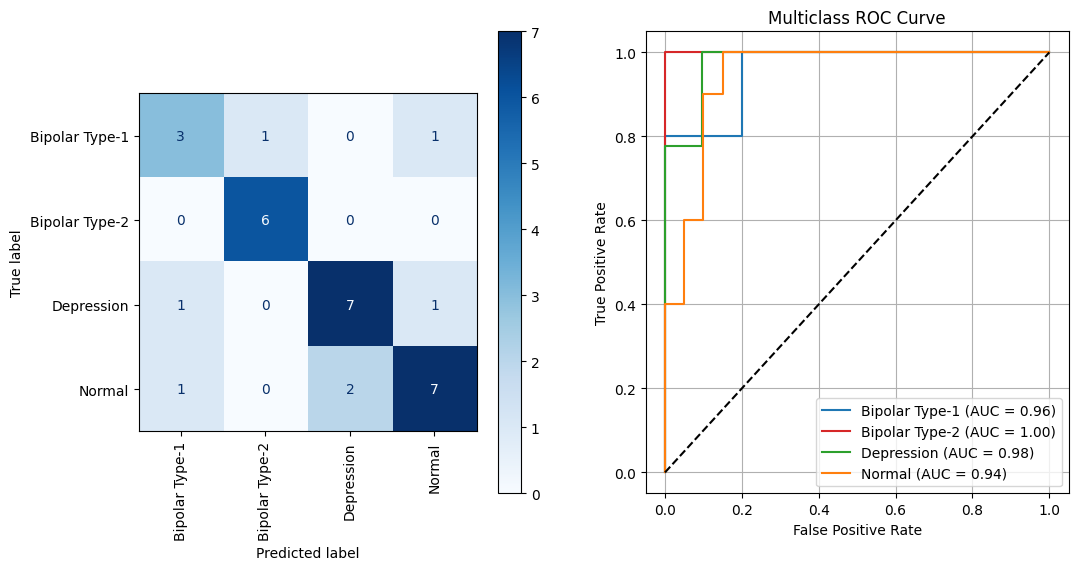

In [122]:
classifier_full = create_random_forest(params_full_dataset)
classifier_full.fit(X_train_full, y_train_full)
plot_CM_and_ROC(classifier_full, X_test_full, y_test_full)

Roc AUC ovr =  0.9589097222222221


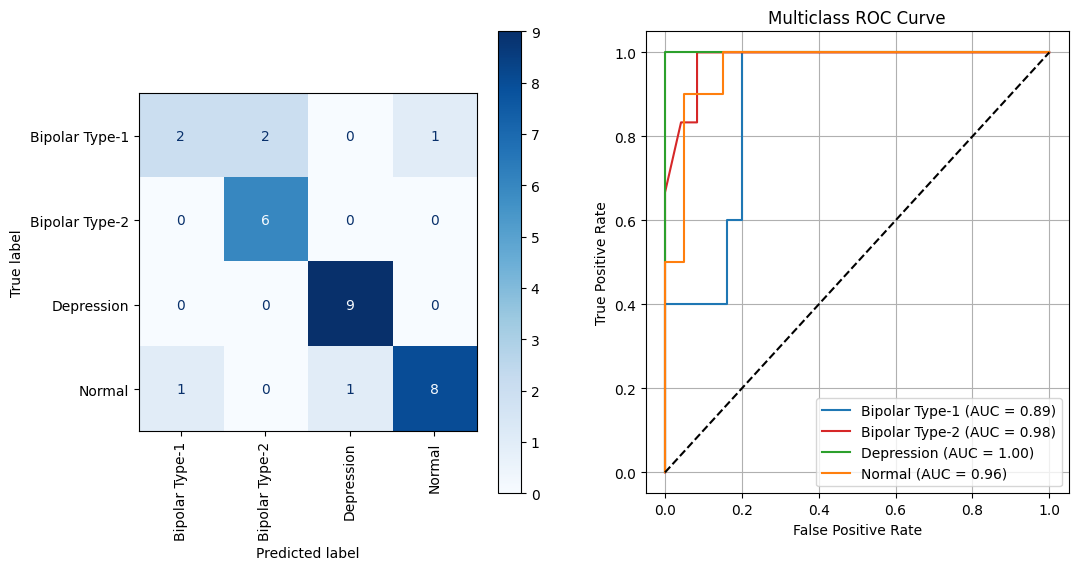

In [123]:
classifier_simple = create_random_forest(params_simplified_dataset, random_state=42)
classifier_simple.fit(X_train_simple, y_train_simple)
plot_CM_and_ROC(classifier_simple, X_test_simple, y_test_simple)

In [124]:
def mcnemar_test(y_true, y_pred1, y_pred2):
    """
    Test McNemara dla porównania dwóch klasyfikatorów.

    H0: Oba klasyfikatory mają tę samą dokładność
    """
    # Tablica kontyngencji 2x2
    # n00: oba błędnie klasyfikują
    # n01: model1 błędnie, model2 poprawnie
    # n10: model1 poprawnie, model2 błędnie
    # n11: oba poprawnie klasyfikują

    correct1 = (y_true == y_pred1)
    correct2 = (y_true == y_pred2)

    n00 = np.sum(~correct1 & ~correct2)
    n01 = np.sum(~correct1 & correct2)
    n10 = np.sum(correct1 & ~correct2)
    n11 = np.sum(correct1 & correct2)

    contingency_table = np.array([[n11, n10], [n01, n00]])

    # Test McNemara z poprawką ciągłości
    statistic = (abs(n01 - n10) - 1)**2 / (n01 + n10) if (n01 + n10) > 0 else 0

    # p-value z rozkładu chi-kwadrat z 1 stopniem swobody
    p_value = 1 - stats.chi2.cdf(statistic, df=1)

    return statistic.item(), p_value.item(), contingency_table

pred_full = classifier_full.predict(X_test_full)
pred_simple = classifier_simple.predict(X_test_simple)
mcnemar_test(y_test_simple, pred_full, pred_simple)

(0.16666666666666666,
 0.6830913983096086,
 array([[21,  2],
        [ 4,  3]]))

In [125]:
from sklearn.metrics import cohen_kappa_score

pred_full = classifier_full.predict(X_test_full)
pred_simple = classifier_simple.predict(X_test_simple)

kappa = cohen_kappa_score(pred_full, pred_simple)
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.7264437689969605


In [126]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(pred_full, pred_simple)
print(f"Multiclass MCC: {mcc}")

Multiclass MCC: 0.729839892572564


In [127]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the report
# We treat 'pred_full' as the "ground truth" to see how well 'pred_simple' mimics it
report_dict = classification_report(pred_full, pred_simple, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Filter to show only the classes (removing averages for now)
class_agreement = report_df.iloc[:-3, :].sort_values(by='f1-score', ascending=False)

print("--- Per-Class Agreement Report ---")
print(class_agreement[['precision', 'recall', 'f1-score']])

--- Per-Class Agreement Report ---
                precision    recall  f1-score
Bipolar Type-2   0.875000  1.000000  0.933333
Normal           0.777778  0.777778  0.777778
Bipolar Type-1   1.000000  0.600000  0.750000
Depression       0.700000  0.777778  0.736842
